In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("train.csv")
data.sample(8)

,review_id,review_text,category
6652,0ace880698d6cfaed2da5a3e64d5262b,airy itu selalu baik tapi kadang hotelnya kaga...,0
7449,55c1faef05d5324edd9ace3ccb58584b,Ga ada anduk dan bantal airy,0
219,3f19442f431c7f62086913e5ef4ac7eb,ac tidak dingin dan kamar nya tidak kedap suara,0
14513,de67cd663946a594dda829f81c4a0638,Banyak penjual makanan d spn hotel,1
1567,cc4a684edecdf6b27bb8f5cbcda78b9c,"pelayanan ramah, namun fasilitas ada yg rusak,...",0
11204,23a3a02fe943c82d8196c32cd3715760,Dari Harga sih rekomended banget\ntapi saya ke...,0
3296,ed05f872daecffe6f0ed753245f9e9c1,kekurangan ada di kemanan. jd pintu di tutup k...,0
5667,e08535af4d822a1c51aa967efd3ceb2d,kamarnya dilantai 3 capek ga ada lift dinding ...,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    14856 non-null  object
 1   review_text  14856 non-null  object
 2   category     14856 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 348.3+ KB


In [4]:
data.isna().sum()#tidak ada data kosong

review_id      0
review_text    0
category       0
dtype: int64

In [5]:
data.drop(['review_id'], axis = 1, inplace = True)

In [6]:
cat = ['review_text']
num = ['category']

In [7]:
for col in cat:
    print(f'''Value count kolom {col}:     ''')
    print(data[col].value_counts())
    print()

Value count kolom review_text:     
harusx ranjangx double bad yg yg d ksih twin                                                                                                                                                                                                              1
dikecewakan oleh karyawan yg membuka pintu kamar seenaknya sendiri. tanpa mengetuk tanpa permisi. sungguh mengecewakan. pertama dan terakhir.                                                                                                             1
ac dingin, kamar sempit, tidak ada air panas, kurang nyaman                                                                                                                                                                                               1
Tempatnya baru bersih nyaman walau agak sedikit nyasar untuk cari tempatnya. Tapi lumayan strategis. good lah pokoknya.                                                                                         

In [8]:
data[cat].describe()#tidak text yang berjumlah lebih dari satu

,review_text
count,14856
unique,14856
top,harusx ranjangx double bad yg yg d ksih twin
freq,1


In [9]:
data.describe()

,category
count,14856.000000
mean,0.135770
std,0.342556
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [10]:
#validasi data
print(data.duplicated().sum())#cek duplicated data
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())#tidak ada data duplicated

0
0


In [11]:
data['length'] = data['review_text'].apply(len)
data.sample(10)

,review_text,category,length
13010,toilet kurg bersih,0,18
8843,Air terlalu kecil. Interior kamar kayak abis g...,0,68
7,"Pelayanannya sangat baik,kmr yang bersih,menu ...",1,99
11686,Yang perlu diperbaiki pelayanan dari seluruh s...,0,55
7537,"tak sesuai espektasi, kamar sempit, pintu kama...",0,138
9870,"Kamarnya bersih, kamar mandi bersih, AC dingin...",1,100
10212,"tidak seperti yang difoto, kurang memuaskan",0,43
174,"kurang baik, ac kamar suka mati\n\n",0,33
14436,"kebersihan sprei dan selimut,dibawah standar a...",0,87
10625,WIFI nggak terhubung,0,20


Text(0.5, 1.0, 'PROPORSI sentiment text(%)')

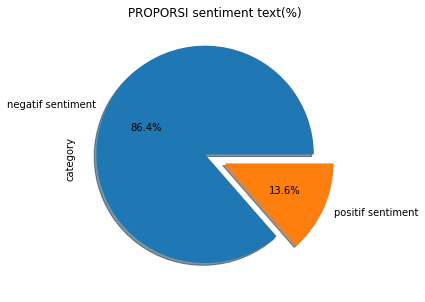

In [13]:
#EDA VISUALIZATION
labels = 'negatif sentiment','positif sentiment'
data['category'].value_counts().plot.pie(explode=[0.1,0.1],labels=labels, autopct='%1.1f%%',shadow=True,figsize=(5,5));
plt.title("PROPORSI sentiment text(%)") #data imbalance perlu tindakan

Text(0.5, 1.0, 'Distribution of length')

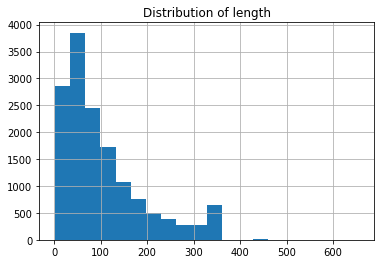

In [14]:
data['length'].hist(bins=20)
plt.title('Distribution of length')#sebaran data ; terlihat range text terbanyak diantara 0-100 huruf 

In [19]:
import plotly
import plotly.graph_objs as go

positif = data[data['category']==1]['review_text'].str.len()
negatif = data[data['category']==0]['review_text'].str.len()
fig = go.Figure()
fig.add_trace(
    go.Histogram(x=positif, xbins=dict(size=200), name='1'),
    )
fig.add_trace(
    go.Histogram(x=negatif, xbins=dict(size=200), name='0'),
    )
fig.update_layout(title='reviewer by text', 
                    xaxis_title="Length",
                    yaxis_title="count of reviewer",)
plotly.offline.iplot(fig)

mayoritas yang memberikan sentiment negatif memiliki 100 huruf pada ulasannya

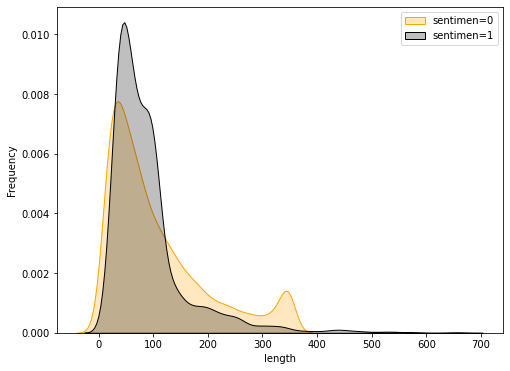

In [21]:
plt.figure(figsize=(8, 6))
g = sns.kdeplot(data["length"][(data["category"] == 0) & (data["length"].notnull())], color="orange", shade = True)
g = sns.kdeplot(data["length"][(data["category"] == 1) & (data["length"].notnull())], ax =g, color="Black", shade= True)
g.set_xlabel("length")
g.set_ylabel("Frequency")
g = g.legend(["sentimen=0","sentimen=1"])

In [22]:
#step 1
data['review_lower'] = data['review_text'].str.lower()
#Step 2: Removing HTML Tags
from bs4 import BeautifulSoup
data['review_lower'] = data['review_lower'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().strip())
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
sw = stopwords.words('indonesian')
def transform_text(s):
    
    # remove html
    html=re.compile(r'<.*?>')
    s = html.sub(r'',s)
    
    # remove numbers
    s = re.sub(r'\d+', '', s)
    
    # remove punctuation
    # remove stopwords
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        # remove words with len = 2 AND stopwords
        if len(w) > 2 and w not in sw:
            new_string.append(w)
 
    s = ' '.join(new_string)
    s = s.strip()

    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    
    return s.strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [24]:
data['review_sw'] = data['review_lower'].apply(transform_text)
data[['review_text','review_lower', 'review_sw']].tail(10)

,review_text,review_lower,review_sw
14846,Keren sekali saya suka puas pokok nya,keren sekali saya suka puas pokok nya,keren suka puas pokok nya
14847,"kamar pengap sekali, masih ada kotoran dibawah...","kamar pengap sekali, masih ada kotoran dibawah...",kamar pengap kotoran dibawah tidur parkir masu...
14848,pelayanan tidak ramah sama sekali......mengece...,pelayanan tidak ramah sama sekali......mengece...,pelayanan ramah mengecewakan
14849,"Kebersihan kurang, saat masuk ke kamar tidak t...","kebersihan kurang, saat masuk ke kamar tidak t...",kebersihan masuk kamar tersedia keset sejadah ...
14850,Toiletnya sgt bau. Sprei tdk diganti masih bau...,toiletnya sgt bau. sprei tdk diganti masih bau...,toiletnya sgt bau sprei tdk diganti bau tamu s...
14851,kotor dan tidak ada wifi,kotor dan tidak ada wifi,kotor wifi
14852,Kamar tidak bersih,kamar tidak bersih,kamar bersih
14853,kamarnya terlalu kecil beberapa cm antara kasu...,kamarnya terlalu kecil beberapa cm antara kasu...,kamarnya kasur dinding
14854,Wifinya sangat kurang memadai..,wifinya sangat kurang memadai..,wifinya memadai
14855,Pelayan sangat sangat buruk. Dulu pelayan nya ...,pelayan sangat sangat buruk. dulu pelayan nya ...,pelayan buruk pelayan nya ramah skrg ganti pel...


In [26]:
from itertools import chain
from collections import Counter
list_words = data['review_sw'].str.split()
list_words_merge = list(chain(*list_words))

d = Counter(list_words_merge)
df = pd.DataFrame(data=d, index=['count'])
top_common_words = df.T.sort_values(by=['count'], ascending=False).reset_index().head(50)
top_common_words.head(10)

,index,count
0,kamar,8473
1,nya,2785
2,mandi,2611
3,air,2522
4,bersih,1986
5,airy,1914
6,hotel,1677
7,kotor,1659
8,bau,1465
9,gak,1449


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

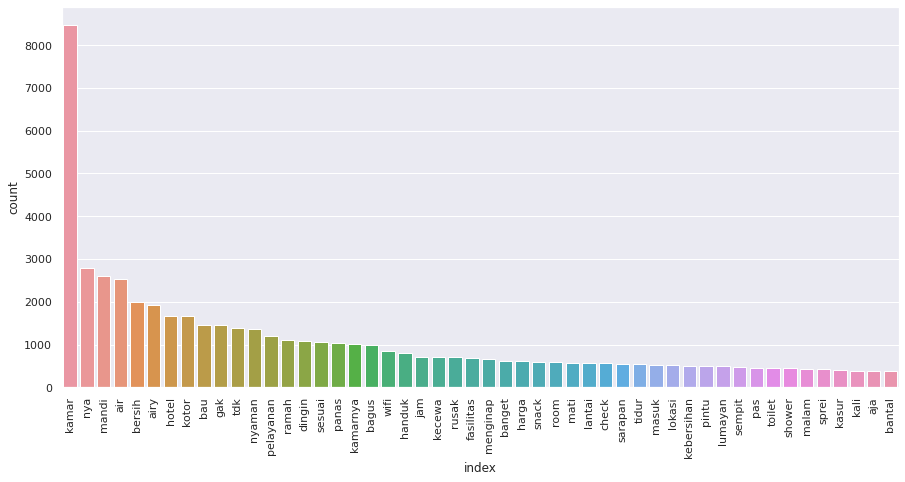

In [27]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.barplot(x="index", y='count', data=top_common_words)
plt.xticks(rotation=90)#komentar terbanyak adalah kamar,mandi, air, bersih, airy, hotel, hotel, kotor, bau

In [28]:
#Step 4: lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 
def lemmatizer_text(s):
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        lem = lemmatizer.lemmatize(w, pos="v")
        # exclude if lenght of lemma is smaller than 2
        if len(lem) > 2:
            new_string.append(lem)
    
    s = ' '.join(new_string)
    return s.strip()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [29]:
data['review_lemma'] = data['review_sw'].apply(lemmatizer_text)
data[['review_text','review_lower', 'review_sw', 'review_lemma']].head(8)

,review_text,review_lower,review_sw,review_lemma
0,"Penginapannya rapi, bersih, suasana tenang, pe...","penginapannya rapi, bersih, suasana tenang, pe...",penginapannya rapi bersih suasana tenang pelay...,penginapannya rapi bersih suasana tenang pelay...
1,"wifi tidak sampai kamar, tidak tersedia heater...","wifi tidak sampai kamar, tidak tersedia heater...",wifi kamar tersedia heater kopiteh dispenser t...,wifi kamar tersedia heater kopiteh dispenser t...
2,"Lantai kamar mandi kotor, bau, dan seperti sdh...","lantai kamar mandi kotor, bau, dan seperti sdh...",lantai kamar mandi kotor bau sdh jdi sarang ny...,lantai kamar mandi kotor bau sdh jdi sarang ny...
3,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...","wc jorok.. kasur tidak dibersihkan,, handuk ti...",jorok kasur dibersihkan handuk diganti,jorok kasur dibersihkan handuk diganti
4,bocor lagi,bocor lagi,bocor,bocor
5,"kebersihan, pelayanan, kerapihan","kebersihan, pelayanan, kerapihan",kebersihan pelayanan kerapihan,kebersihan pelayanan kerapihan
6,saya hampir tidak bisa tidur krn bantal sangat...,saya hampir tidak bisa tidur krn bantal sangat...,tidur krn bantal bau apek,tidur krn bantal bau apek
7,"Pelayanannya sangat baik,kmr yang bersih,menu ...","pelayanannya sangat baik,kmr yang bersih,menu ...",pelayanannya kmr bersih menu makanannya enak s...,pelayanannya kmr bersih menu makanannya enak s...


In [32]:
string = ' '.join(data['review_lemma'])
str_val = string.split(" ")

In [33]:
#unigram analysis
data_unigram=(pd.Series(nltk.ngrams(str_val, 1)).value_counts())[:30]
data_unigram_df=pd.DataFrame(data_unigram)
data_unigram_df = data_unigram_df.reset_index()
data_unigram_df = data_unigram_df.rename(columns={"index": "key", 0: "value"})
data_unigram_df.head()

,key,value
0,"(kamar,)",8473
1,"(nya,)",2785
2,"(mandi,)",2611
3,"(air,)",2522
4,"(bersih,)",1986


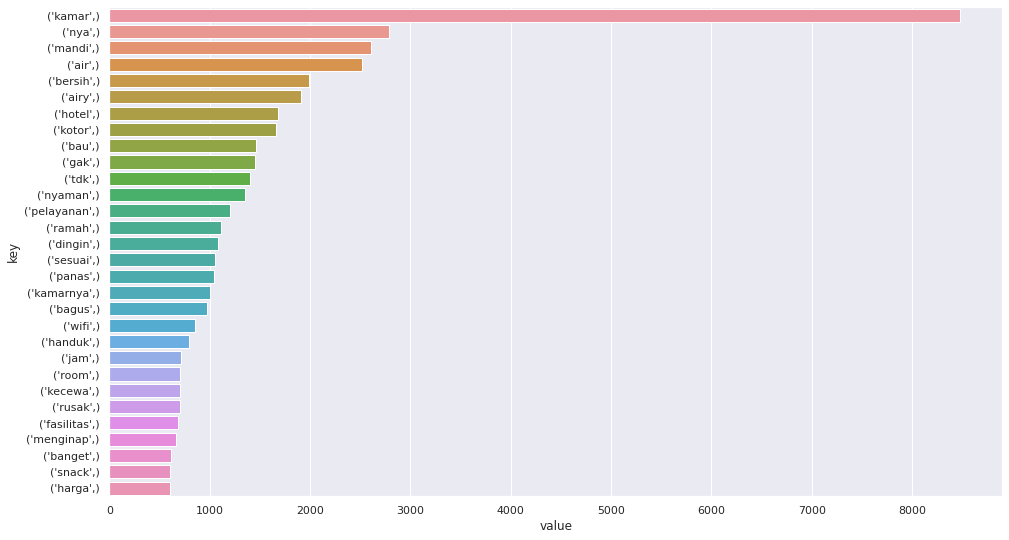

In [34]:
#unigram
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_unigram_df)

In [35]:
#bigram analysis
data_bigram=(pd.Series(nltk.ngrams(str_val, 2)).value_counts())[:30]
data_bigram_df=pd.DataFrame(data_bigram)
data_bigram_df = data_bigram_df.reset_index()
data_bigram_df = data_bigram_df.rename(columns={"index": "key", 0: "value"})
data_bigram_df.head(10)

,key,value
0,"(kamar, mandi)",1789
1,"(air, panas)",722
2,"(kamar, bersih)",357
3,"(airy, room)",294
4,"(kamar, mandinya)",284
5,"(kamar, bau)",235
6,"(mandi, kotor)",221
7,"(kamar, kotor)",220
8,"(kamar, kamar)",219
9,"(pintu, kamar)",216


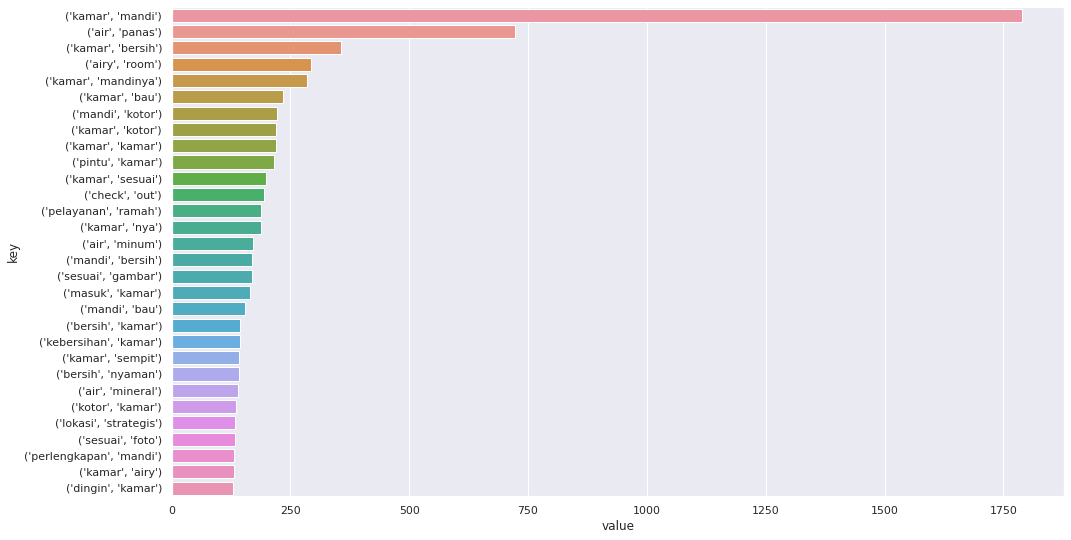

In [36]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_bigram_df)

In [37]:
#trigram analysis
data_trigram=(pd.Series(nltk.ngrams(str_val, 3)).value_counts())[:30]
data_trigram_df=pd.DataFrame(data_trigram)
data_trigram_df = data_trigram_df.reset_index()
data_trigram_df = data_trigram_df.rename(columns={"index": "key", 0: "value"})
data_trigram_df.head(10)

,key,value
0,"(kamar, mandi, kotor)",209
1,"(kamar, mandi, bersih)",156
2,"(pintu, kamar, mandi)",139
3,"(kamar, mandi, bau)",138
4,"(air, kamar, mandi)",95
5,"(kamar, mandi, nya)",89
6,"(kamar, mandi, rusak)",87
7,"(kamar, kamar, mandi)",76
8,"(kotor, kamar, mandi)",58
9,"(air, panas, berfungsi)",56


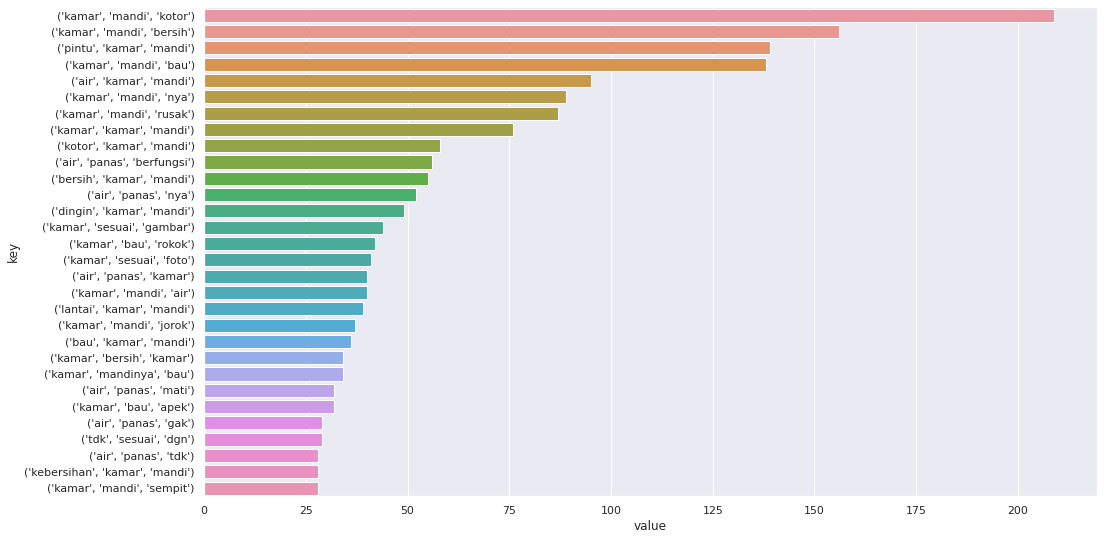

In [38]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_trigram_df)

In [41]:
# Creating Frequency
text_series = pd.Series(string.split())
freq_comm = text_series.value_counts()
freq_comm

kamar       8473
nya         2785
mandi       2611
air         2522
bersih      1986
            ... 
luber          1
disebelh       1
dikelola       1
prasana        1
bida           1
Length: 13558, dtype: int64

In [50]:
rare_words = freq_comm[-8000:-1]
'rattlecrackle' in rare_words
rare_words

lambta               1
perlengkpan          1
yth                  1
tertawa              1
dicaritersembunyi    1
                    ..
puter                1
luber                1
disebelh             1
dikelola             1
prasana              1
Length: 7999, dtype: int64

In [51]:
# Removing 8000 rare occuring words 
data['review_lemma'] = data['review_lemma'].apply(lambda x: ' '.join([word for word in x.split() if word not in rare_words]))
data['review_lemma'].head(10)

0    penginapannya rapi bersih suasana tenang pelay...
1    wifi kamar tersedia heater kopiteh dispenser t...
2    lantai kamar mandi kotor bau sdh jdi sarang ny...
3               jorok kasur dibersihkan handuk diganti
4                                                bocor
5                       kebersihan pelayanan kerapihan
6                            tidur krn bantal bau apek
7    pelayanannya kmr bersih menu makanannya enak s...
8           kamar kecoa tlg diperhatikan kebersihannya
9                                   kamar mandi banjir
Name: review_lemma, dtype: object

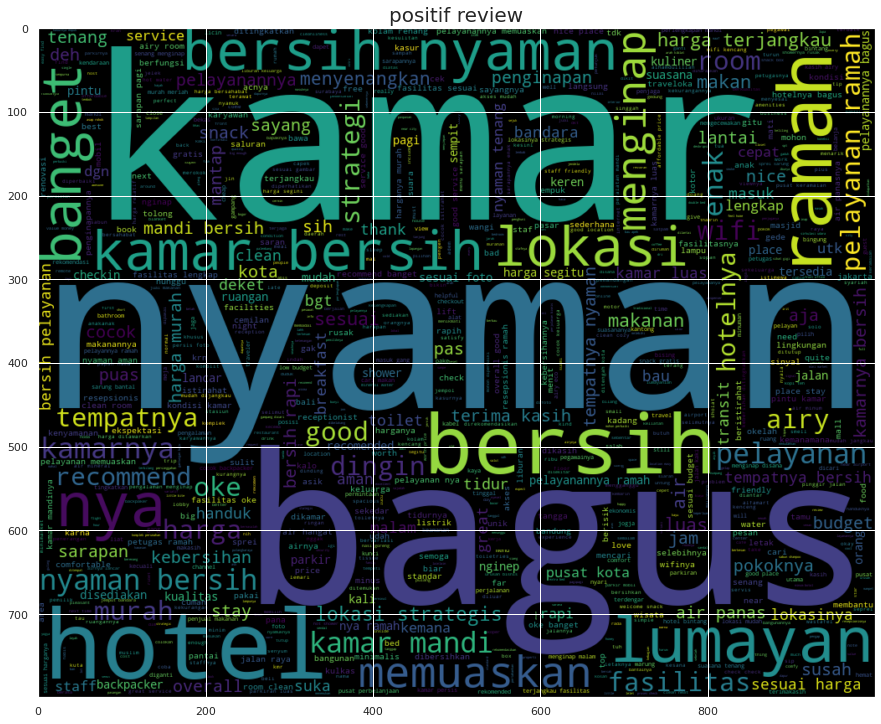

In [61]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))#wordcloud positif sentiment
wc = WordCloud(max_words = 8000 , width = 1000 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.category == 1].review_lemma))
plt.title('positif review',size=20)
plt.imshow(wc , interpolation = 'bilinear')

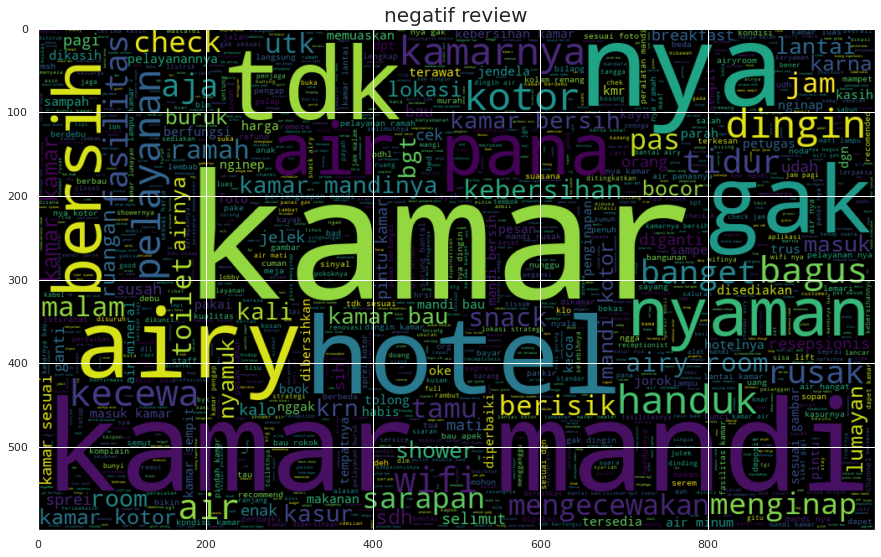

In [60]:
plt.figure(figsize = (15,15))#wordcloud negatif sentiment
wc = WordCloud(max_words = 8000 , width = 1000 , height = 600 , stopwords = STOPWORDS).generate(" ".join(data[data.category == 0].review_lemma))
plt.title('negatif review',size=20)
plt.imshow(wc , interpolation = 'bilinear')

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
#look predict by rating
X = data['review_lemma']
y = data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=95)
vecto = CountVectorizer(binary=True)
X_train_vecto = vecto.fit_transform(X_train)
X_test_vecto = vecto.transform(X_test)

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rf = RandomForestClassifier(random_state = 95)
rf.fit(X_train_vecto, y_train)
print(classification_report(y_test, rf.predict(X_test_vecto)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2576
           1       0.80      0.52      0.63       396

    accuracy                           0.92      2972
   macro avg       0.87      0.75      0.79      2972
weighted avg       0.91      0.92      0.91      2972



In [65]:
rf3 = RandomForestClassifier(class_weight = 'balanced')
rf3.fit(X_train_vecto, y_train)
print(classification_report(y_test, rf3.predict(X_test_vecto)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2576
           1       0.82      0.49      0.61       396

    accuracy                           0.92      2972
   macro avg       0.87      0.74      0.78      2972
weighted avg       0.91      0.92      0.91      2972



In [66]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(X_train_vecto, y_train)
print(classification_report(y_test, NB.predict(X_test_vecto)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2576
           1       0.73      0.70      0.72       396

    accuracy                           0.93      2972
   macro avg       0.84      0.83      0.84      2972
weighted avg       0.93      0.93      0.93      2972



In [67]:
from xgboost import XGBClassifier
classifier1 = XGBClassifier()
classifier1.fit(X_train_vecto, y_train)
print(classification_report(y_test, classifier1.predict(X_test_vecto)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2576
           1       0.87      0.35      0.50       396

    accuracy                           0.91      2972
   macro avg       0.89      0.67      0.72      2972
weighted avg       0.90      0.91      0.89      2972



In [68]:
#use by deep learning
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [69]:
# create the tokenizer
tokenizer = Tokenizer()

# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)
# encode training data set
Xtrain = tokenizer.texts_to_matrix(X_train, mode='count')

# encode training data set
Xtest = tokenizer.texts_to_matrix(X_test, mode='count')

n_words1 = Xtest.shape[1]

print("n_words1", n_words1)

n_words1 5454


In [71]:
model = tf.keras.models.Sequential([
       
    tf.keras.layers.Dense(500, input_shape=(n_words1,), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
          
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [73]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(Xtrain, y_train,
                    epochs=100,
                    validation_data=(Xtest, y_test,),
                    verbose=1,
                    callbacks=callbacks,
                   )

Epoch 1/100
372/372 [==============================] - 11s 26ms/step - loss: 0.8636 - acc: 0.5835 - val_loss: 0.4458 - val_acc: 0.9095
Epoch 2/100
372/372 [==============================] - 10s 26ms/step - loss: 0.5368 - acc: 0.7491 - val_loss: 0.3263 - val_acc: 0.8906
Epoch 3/100
372/372 [==============================] - 10s 26ms/step - loss: 0.3713 - acc: 0.8472 - val_loss: 0.2622 - val_acc: 0.9122
Epoch 4/100
372/372 [==============================] - 9s 25ms/step - loss: 0.2669 - acc: 0.9030 - val_loss: 0.2254 - val_acc: 0.9236
Epoch 5/100
372/372 [==============================] - 10s 27ms/step - loss: 0.2152 - acc: 0.9276 - val_loss: 0.2077 - val_acc: 0.9280
Epoch 6/100
372/372 [==============================] - 10s 27ms/step - loss: 0.1712 - acc: 0.9460 - val_loss: 0.2017 - val_acc: 0.9314
Epoch 7/100
372/372 [==============================] - 10s 26ms/step - loss: 0.1418 - acc: 0.9545 - val_loss: 0.2060 - val_acc: 0.9293
Epoch 8/100
372/372 [==============================] - 1

In [75]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

counter = Counter(y_train)
print('Before',counter)

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train_vecto, y_train)
counter = Counter(y_ros)
print('After',counter)

Before Counter({0: 10263, 1: 1621})
After Counter({1: 10263, 0: 10263})


In [76]:
rf1 = RandomForestClassifier()
rf1.fit(X_ros, y_ros)
print(classification_report(y_test, rf1.predict(X_test_vecto)))
#tidak mengalami perubahan ketika dilakukan undersampler

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2576
           1       0.74      0.59      0.66       396

    accuracy                           0.92      2972
   macro avg       0.84      0.78      0.81      2972
weighted avg       0.91      0.92      0.91      2972



model terbaik adalah deep learning dengan akuarasi skor 93,24% tetapi perlu estimasi proses yang lumayan lama, sehingga ada opsi lain yaitu model naive bayes